In [ ]:
%run init_notebook.py

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio.transforms as T
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import Audio, display
import matplotlib.pyplot as plt

from src.dataset import NSynth
from src.models import AutoEncoder, VAE
from src.utils.models import compute_magnitude_and_phase, adjust_shape
from src.utils.logger import save_training_results
from src.utils.losses import MultiResolutionSTFTLoss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# paths
ae_path = r"C:\Users\Articuno\Desktop\TFG-info\data\models\autoencoder.pth"
vae_path = r"C:\Users\Articuno\Desktop\TFG-info\data\models\vae.pth"
 
# STFT params
sample_rate = 16000
n_fft      = 1500
hop_length = 250
win_length = n_fft

input_h, input_w = n_fft, 1 + (64000 - n_fft) // hop_length
latent_dim      = 200
lr              = 1e-4

# Transformation definitions
stft_transform = T.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=None, onesided=False, center=False).to(device)
istft_transform = T.InverseSpectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length, onesided=False).to(device)

In [ ]:
# data
train_ds = NSynth('training')
valid_ds = NSynth('validation')
test_ds  = NSynth('testing')

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=True, pin_memory=True)

Encoder:  Encoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=385024, out_features=200, bias=True)
  (fc2): Linear(in_features=385024, out_features=200, bias=True)
)
Decoder:  Decoder(
  (fc): Linear(in_features=200, out_features=385024, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(64,

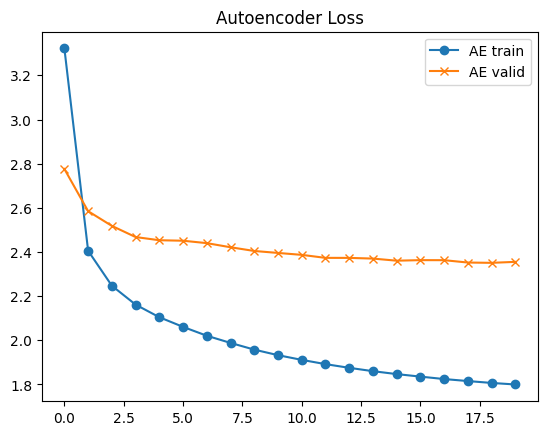

In [ ]:
### ── PHASE 1: AUTOENCODER PRETRAIN ────────────────────────────────
ae = AutoEncoder((input_h, input_w), latent_dim).to(device)
criterion = nn.MSELoss()
opt_ae    = optim.Adam(ae.parameters(), lr=lr)
sched_ae  = ReduceLROnPlateau(opt_ae, 'min', patience=3, factor=0.5)
num_epochs = 20
total_ae_time = 0.0

best_val = float('inf')
ae_hist = {'train': [], 'valid': []}
print(">> Phase 1: training AutoEncoder")
for epoch in range(1, num_epochs + 1):
    ae.train()
    running = 0
    start = time.time()
    for wav, *_ in train_loader:
        wav = wav.to(device)
        S   = stft_transform(wav)
        mag, ph = compute_magnitude_and_phase(S)
        inp = torch.cat([mag, ph], dim=1)
        opt_ae.zero_grad()
        out = ae(inp)
        loss = criterion(out, inp)
        loss.backward()
        opt_ae.step()
        running += loss.item() * wav.size(0)
    train_loss = running / len(train_loader.dataset)

    ae.eval()
    running = 0
    with torch.no_grad():
        for wav, *_ in valid_loader:
            wav = wav.to(device)
            S   = stft_transform(wav)
            mag, ph = compute_magnitude_and_phase(S)
            inp = torch.cat([mag, ph], dim=1)
            out = ae(inp)
            running += criterion(out, inp).item() * wav.size(0)
    valid_loss = running / len(valid_loader.dataset)

    sched_ae.step(valid_loss)
    ae_hist['train'].append(train_loss)
    ae_hist['valid'].append(valid_loss)

    epoch_time = time.time() - start
    total_ae_time += epoch_time
    print(f"AE Epoch {epoch:2d}: train={train_loss:.4f} valid={valid_loss:.4f} time={epoch_time:.1f}s")

    if valid_loss < best_val:
        best_val = valid_loss
        torch.save(ae.state_dict(), ae_path)
print(">> AutoEncoder training complete.\n")

# Save last model as well
torch.save(ae.state_dict(), ae_path.replace('.pth','_last.pth'))

save_training_results({
    "train_losses": ae_hist['train'],
    "valid_losses": ae_hist['valid'],
    "recon_losses": [],       # not used in AE
    "KL_losses": [],          # not used in AE
    "num_epochs": len(ae_hist['train']),
    "avg_epoch_time": total_ae_time / num_epochs,  # however you’re tracking it
    "learning_rate": lr,
    "batch_size": batch_size,
    "sample_rate": sample_rate,
    "n_fft": n_fft,
    "hop_length": hop_length,
    "input_height": input_h,
    "input_width": input_w,
    "latent_dim": latent_dim,
}, "autoencoder.json")

# plot AE losses

plt.plot(ae_hist['train'], marker='o', label='AE train')
plt.plot(ae_hist['valid'], marker='x', label='AE valid')
plt.title("Autoencoder Loss")
plt.legend(); plt.show()




In [ ]:
### ── PHASE 2: VAE FINE-TUNE ───────────────────────────────────────
# reuse same architecture but now variational=True

vae = VAE((input_h, input_w), latent_dim).to(device)
# load pretrained encoder+decoder weights into VAE
_ae_dict = torch.load(ae_path)
_vae_dict = vae.state_dict()
# copy only matching keys (encoder & decoder)
for k,v in _ae_dict.items():
    if k in _vae_dict: _vae_dict[k] = v
vae.load_state_dict(_vae_dict)

mrstft = MultiResolutionSTFTLoss(
    orig_n_fft      = n_fft,
    orig_hop_length = hop_length,
    orig_win_length = win_length,
    fft_sizes=(512,1024,2048),
    hop_sizes=(120,240,480),
    win_lengths=(512,1024,2048),
    weight=0.1,
).to(device)

opt_vae   = optim.Adam(vae.parameters(), lr=lr)
sched_vae = ReduceLROnPlateau(opt_vae, 'min', patience=3, factor=0.5)

best_val = float('inf')
vae_hist = { 'train':[], 'valid':[], 'recon':[], 'kl':[] }
patience_es = 5
stall = 0
warmup = 10
kl_annealing = True
total_vae_time = 0.0

print(">> Phase 2: training VAE")
for epoch in range(1, num_epochs + 1):
    beta = min(1.0, epoch / warmup) if kl_annealing else 1
    vae.train()

    run_tot = run_recon = run_kl = 0.0
    start = time.time()
    for wav, *_ in train_loader:
        wav = wav.to(device)
        S   = stft_transform(wav)
        mag, ph = compute_magnitude_and_phase(S)
        inp = torch.cat([mag, ph], dim=1)    # [B,2,F,T]

        # 1) forward‐encode → ELBO terms
        opt_vae.zero_grad()
        logpx, kld = vae(inp)                # your calculate_elbo

        # 2) re‐run encoder+decoder to get x_hat for spectral loss
        #    (we need the actual reconstruction, not just logpx)
        _, mu, logvar = vae.encoder(inp)
        z = vae.reparameterization(mu, logvar)
        x_hat = vae.decoder(z)
        x_hat = adjust_shape(x_hat, (input_h, input_w))

        # 3) spectral loss
        spec_loss = mrstft(inp, x_hat)

        # 4) ELBO
        elbo = (logpx - beta * kld).mean()

        # 5) total loss = –ELBO + spectral penalty
        loss = -elbo + spec_loss

        # 6) bookkeeping
        recon = (-logpx).sum().item()
        run_recon += recon
        run_kl    += kld.sum().item()

        # 7) backward + step
        loss.backward()
        opt_vae.step()
        run_tot += loss.item() * wav.size(0)

    N = len(train_loader.dataset)
    train_loss = run_tot / N
    vae_hist['train'].append(train_loss)
    vae_hist['recon'].append(run_recon / N)
    vae_hist['kl'].append(run_kl / N)

    vae.eval()
    run_v = 0
    with torch.no_grad():
        for wav, *_ in valid_loader:
            wav = wav.to(device)
            S   = stft_transform(wav)
            mag, ph = compute_magnitude_and_phase(S)
            inp = torch.cat([mag, ph], dim=1)
            logpx, kld = vae(inp)
            run_v += vae.loss_function(logpx, kld, beta).item() * wav.size(0)
    valid_loss = run_v / len(valid_loader.dataset)
    vae_hist['valid'].append(valid_loss)

    sched_vae.step(valid_loss)

    epoch_time = time.time() - start
    total_vae_time += epoch_time
    print(f"VAE E{epoch:2d}: β={beta:.2f} train={train_loss:.4f} valid={valid_loss:.4f} time={epoch_time:.1f}s")

    # early stop only after warmup
    if epoch > warmup:
        if valid_loss < best_val:
            best_val = valid_loss
            stall = 0
            torch.save(vae.state_dict(), vae_path)
        else:
            stall += 1
            if stall >= patience_es:
                print(f" no improvement for {stall} epochs → stop.")
                break

# Save last model as well
torch.save(vae.state_dict(), vae_path.replace('.pth','_last.pth'))

save_training_results({
    "train_losses": vae_hist['train'],
    "valid_losses": vae_hist['valid'],
    "recon_losses": vae_hist['recon'],
    "KL_losses": vae_hist['kl'],
    "num_epochs": len(vae_hist['train']),
    "avg_epoch_time": total_vae_time / len(vae_hist['train']),
    "learning_rate": lr,
    "batch_size": batch_size,
    "sample_rate": sample_rate,
    "n_fft": n_fft,
    "hop_length": hop_length,
    "input_height": input_h,
    "input_width": input_w,
    "latent_dim": latent_dim,
    "patience": patience_es,
    "warmup": warmup,
    "kl_annealing": kl_annealing,
}, "vae.json")

# final plots
plt.figure(figsize=(10,4))
e = range(1,len(vae_hist['train'])+1)
plt.plot(e, vae_hist['train'],label='Training'); plt.plot(e,vae_hist['valid'],label='Validation')
plt.title("VAE Total Loss"); plt.legend(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(e, vae_hist['recon'],marker='o', label='Reconstruction')
plt.plot(e, vae_hist['kl'],  marker='x', label='KL')
plt.title("VAE Recon vs KL"); plt.legend(); plt.show()

Encoder: Encoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=385024, out_features=200, bias=True)
  (fc2): Linear(in_features=385024, out_features=200, bias=True)
)
Decoder: Decoder(
  (fc): Linear(in_features=200, out_features=385024, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(64, 188, 32))
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
 

TypeError: MultiResolutionSTFTLoss.__init__() got an unexpected keyword argument 'orig_n_fft'

In [ ]:
vae.eval()

num_samples = 10

# 1) Sample from the standard Normal prior
Z = torch.randn(num_samples, latent_dim, device=device)

with torch.no_grad():
    # 2) Decode
    decoded = vae.decoder(Z)                            # (B, 2, H', W')
    decoded = adjust_shape(decoded, (input_h, input_w)) # (B, 2, H, W)

    # 3) Split into mag & phase
    mag   = decoded[:, 0, :, :]      # (B, H, W)
    phase = decoded[:, 1, :, :]      # (B, H, W)

    # 4) Clamp magnitude >= 0
    # mag = torch.relu(mag)

    # 5) Reconstruct complex STFT and invert
    complex_stft   = mag * torch.exp(1j * phase)  # (B, H, W)
    reconstructed = istft_transform(complex_stft) # (B, T)

# 6) Listen
for i in range(num_samples):
    print(f"\n=== Generated Sample {i+1} ===")
    waveform = reconstructed[i].squeeze().cpu().numpy()
    display(Audio(waveform, rate=sample_rate))



=== Generated Sample 1 ===



=== Generated Sample 2 ===



=== Generated Sample 3 ===



=== Generated Sample 4 ===



=== Generated Sample 5 ===



=== Generated Sample 6 ===



=== Generated Sample 7 ===



=== Generated Sample 8 ===



=== Generated Sample 9 ===



=== Generated Sample 10 ===


# Plotting the latent space

Encoder: Encoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=385024, out_features=200, bias=True)
  (fc2): Linear(in_features=385024, out_features=200, bias=True)
)
Decoder: Decoder(
  (fc): Linear(in_features=200, out_features=385024, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(64, 188, 32))
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
 

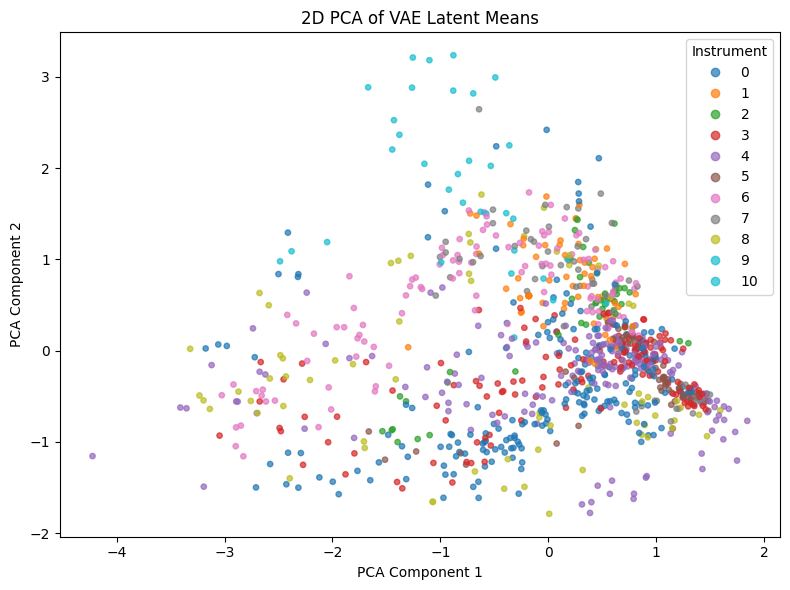

In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torchaudio.transforms as T

from src.dataset import NSynth
from src.models import VAE
from src.utils.models import compute_magnitude_and_phase

# 1) STFT pipeline (must match training)
stft_transform = T.Spectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length,
    power=None, onesided=False, center=False
).to(device)

# 2) Load your trained VAE
vae = VAE((input_h, input_w), latent_dim).to(device)
vae.load_state_dict(torch.load(vae_path))
vae.eval()

# 3) Gather N posterior means + labels
N = 1000
mus, labels = [], []
loader = DataLoader(NSynth('testing'),
                    batch_size=batch_size,
                    shuffle=True,
                    pin_memory=True)

with torch.no_grad():
    for wav, _, _, metadata in loader:
        wav = wav.to(device)
        S   = stft_transform(wav)                    # [B,1,F,T]
        mag, ph = compute_magnitude_and_phase(S)     # each [B,1,F,T]
        x   = torch.cat([mag, ph], dim=1)            # [B,2,F,T]

        _, mu, _ = vae.encoder(x)                    # [B, latent_dim]
        mus.append(mu.cpu().numpy())

        # instrument labels
        oh = metadata['one_hot_instrument']
        for v in oh:
            labels.append(int(v.argmax()))

        if len(labels) >= N:
            break

mus    = np.vstack(mus)[:N]        # (N, latent_dim)
labels = np.array(labels[:N])      # (N,)

# 4) PCA → 2D
pca = PCA(n_components=2)
z2  = pca.fit_transform(mus)       # (N,2)

# 5) Plot
plt.figure(figsize=(8,6))
sc = plt.scatter(z2[:,0], z2[:,1],
                 c=labels, cmap='tab10',
                 s=15, alpha=0.7)
plt.legend(*sc.legend_elements(),
           title="Instrument", loc='upper right')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA of VAE Latent Means")
plt.tight_layout()
plt.show()
